In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from tensorflow.keras.utils import image_dataset_from_directory
from itertools import product
from sklearn.utils.class_weight import compute_class_weight
from google.colab import drive



In [2]:
# Mount Google Drive
drive.mount('/content/drive')

# --- Define Paths ---
main_data_dir = "/content/drive/MyDrive/bone_data"
# This is the second, final hold-out test set
second_test_dir = "/content/drive/MyDrive/test"
def load_and_split_main_data(data_dir, img_size=(224, 224), batch_size=32):
    """
    Loads data from the main directory and splits it into training, validation,
    and a *first* test set using the recommended .take() and .skip() methods.
    """
    full_dataset = image_dataset_from_directory(
        data_dir,
        labels='inferred',
        label_mode='int',
        image_size=img_size,
        shuffle=True,
        seed=42,
        batch_size=batch_size
    )
    class_names = full_dataset.class_names

    # Extract labels to calculate class weights
    labels = np.concatenate([y for x, y in full_dataset], axis=0)
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(labels),
        y=labels
    )
    class_weights = dict(enumerate(class_weights))
    print("Class Names:", class_names)
    print("Class Weights:", class_weights)

    # Determine the size of the dataset in batches
    # Using tf.data.experimental.cardinality is safer than len()
    total_size_in_batches = tf.data.experimental.cardinality(full_dataset).numpy()

    # Define split sizes in terms of batches
    test_size_in_batches = int(total_size_in_batches * 0.10)
    val_size_in_batches = int(total_size_in_batches * 0.15)
    train_size_in_batches = total_size_in_batches - test_size_in_batches - val_size_in_batches

    # Use .take() and .skip() for a robust split
    test1_data_tf = full_dataset.take(test_size_in_batches)
    val_data_tf = full_dataset.skip(test_size_in_batches).take(val_size_in_batches)
    train_data_tf = full_dataset.skip(test_size_in_batches + val_size_in_batches)

    # Helper to convert tf.data.Dataset to NumPy
    def to_numpy(dataset):
        images, labels = [], []
        for x, y in dataset:
            images.append(x.numpy())
            labels.append(y.numpy())
        if not images:
            return np.array([]), np.array([])
        return np.concatenate(images), np.concatenate(labels)

    train_x, train_y = to_numpy(train_data_tf)
    val_x, val_y = to_numpy(val_data_tf)
    test1_x, test1_y = to_numpy(test1_data_tf)

    return (train_x, train_y), (val_x, val_y), (test1_x, test1_y), class_names, class_weights


def load_second_test_set(data_dir, img_size=(224, 224), batch_size=32):
    """Loads the second, separate test set."""
    test_dataset = image_dataset_from_directory(
        data_dir, labels='inferred', label_mode='int',
        image_size=img_size, shuffle=False, batch_size=batch_size
    )
    images, labels = [], []
    for batch_images, batch_labels in test_dataset:
        images.append(batch_images.numpy())
        labels.append(batch_labels.numpy())
    return np.concatenate(images), np.concatenate(labels)


# --- Load Data for Stage 1 ---
(train_x, train_y), (val_x, val_y), (test1_x, test1_y), class_names, class_weights = load_and_split_main_data(main_data_dir)


def load_second_test_set(data_dir, img_size=(224, 224), batch_size=32):
    """Loads the second, separate test set."""
    test_dataset = image_dataset_from_directory(
        data_dir,
        labels='inferred',
        label_mode='int',
        image_size=img_size,
        shuffle=False,
        batch_size=batch_size
    )
    # Convert to NumPy
    images, labels = [], []
    for batch_images, batch_labels in test_dataset:
        images.append(batch_images.numpy())
        labels.append(batch_labels.numpy())
    return np.concatenate(images), np.concatenate(labels)


# --- Load Data for Stage 1 ---
(train_x, train_y), (val_x, val_y), (test1_x, test1_y), class_names, class_weights = load_and_split_main_data(main_data_dir)



Mounted at /content/drive
Found 2127 files belonging to 2 classes.
Class Names: ['fracture', 'normal']
Class Weights: {0: np.float64(0.53175), 1: np.float64(8.374015748031496)}
Found 2127 files belonging to 2 classes.
Class Names: ['fracture', 'normal']
Class Weights: {0: np.float64(0.53175), 1: np.float64(8.374015748031496)}


In [3]:

def build_transfer_model(input_shape, n_classes, dropout=0.3, lr=0.001, l2_strength=0.01):
    """Builds and compiles the ResNet50-based transfer learning model."""
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
    base_model.trainable = False
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(n_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizers.Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print(f"Number of layers in the model: {len(model.layers)}")
    return model

# --- Hyperparameter Grid Search ---
param_grid = {
    "dropout": [0.2, 0.3], "learning_rate": [0.1, 0.01],
    "batch_size": [32, 64], "epochs": [10, 5]
}


combinations = list(product(param_grid['dropout'], param_grid['learning_rate'], param_grid['batch_size'], param_grid['epochs']))

best_accuracy = 0
best_config = None
best_model = None

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

for dropout, lr, batch_size, epochs in combinations:
    print(f"\n--- Training: dropout={dropout}, lr={lr}, batch={batch_size}, epochs={epochs} ---")
    model = build_transfer_model((224, 224, 3), len(class_names), dropout=dropout, lr=lr)
    history = model.fit(
        train_x, train_y, validation_data=(val_x, val_y),
        epochs=epochs, batch_size=batch_size, class_weight=class_weights,
        verbose=1, callbacks=[early_stopping]
    )
    val_acc = max(history.history['val_accuracy'])
    if val_acc > best_accuracy:
        print(f"!!! New best model found with Validation Accuracy: {val_acc:.2%} !!!")
        best_accuracy = val_acc
        best_config = (dropout, lr, batch_size, epochs)
        best_model = model





--- Training: dropout=0.2, lr=0.1, batch=32, epochs=10 ---
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Number of layers in the model: 7
Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 34s 374ms/step - accuracy: 0.6179 - loss: 215.9725 - val_accuracy: 0.9563 - val_loss: 69.0777
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.8161 - loss: 80.8981 - val_accuracy: 0.7937 - val_loss: 58.1315
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - accuracy: 0.7925 - loss: 33.9233 - val_accuracy: 0.9625 - val_loss: 14.1803
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.8929 - loss: 10.0069 - val_accuracy: 0.7250 - val_loss: 3.6288
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.8401 - loss: 2.7999 - val_accuracy: 0.9625 - val_loss: 1.7191
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - accuracy: 0.7338 - loss: 4.0470 - val_accuracy: 0.9594 - val_loss: 3.1395
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.8055 - l

In [13]:

def evaluate_and_report(model, test_x, test_y, class_names, test_set_name):
    """A helper function to run evaluation and print all reports."""
    print("\n" + "="*40)
    print(f"--- Evaluation on {test_set_name} ---")
    print("="*40)

    preds = model.predict(test_x)
    y_pred = np.argmax(preds, axis=1)

    test_accuracy = accuracy_score(test_y, y_pred)
    test_f1 = f1_score(test_y, y_pred, average='weighted')

    print(f"\n{test_set_name} Accuracy: {test_accuracy:.2%}")
    print(f"{test_set_name} F1 Score: {test_f1:.2%}")

    print("\nClassification Report:")
    print(classification_report(test_y, y_pred, target_names=class_names))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(test_y, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix on {test_set_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # --- Display a sample of correctly and incorrectly classified images ---
    correct_indices = np.where(y_pred == test_y)[0]
    misclassified_indices = np.where(y_pred != test_y)[0]

    print(f"\n--- Sample of Correctly Classified Images from {test_set_name} ---")
    if len(correct_indices) > 0:
      plt.figure(figsize=(15, 4))
      for i, idx in enumerate(np.random.choice(correct_indices, size=min(5, len(correct_indices)), replace=False)):
          plt.subplot(1, 5, i + 1)
          plt.imshow(test_x[idx].astype('uint8'))
          plt.title(f"True: {class_names[test_y[idx]]}\nPred: {class_names[y_pred[idx]]}", color='green')
          plt.axis('off')
      plt.show()





--- Best Model Details ---
Best Config (dropout, lr, batch, epochs): (0.2, 0.01, 64, 5)
Best Validation Accuracy during training: 99.06%

--- Evaluation on First Test Set ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step

First Test Set Accuracy: 98.44%
First Test Set F1 Score: 98.26%

Classification Report:
              precision    recall  f1-score   support

    fracture       0.98      1.00      0.99       184
      normal       1.00      0.62      0.77         8

    accuracy                           0.98       192
   macro avg       0.99      0.81      0.88       192
weighted avg       0.98      0.98      0.98       192


Confusion Matrix:


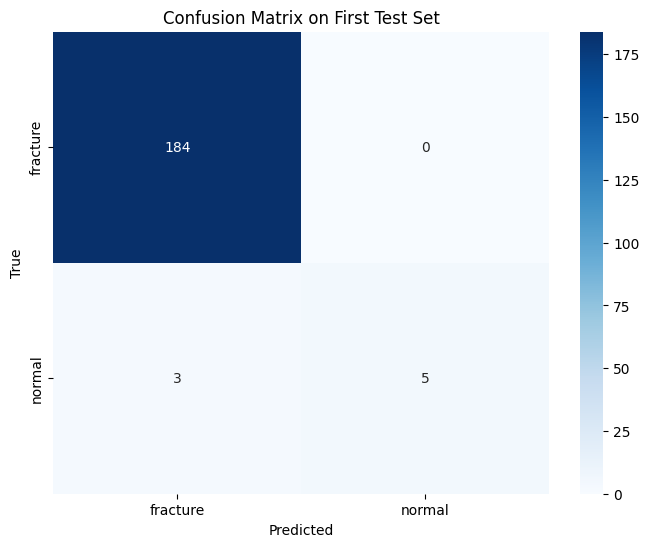


--- Sample of Correctly Classified Images from First Test Set ---


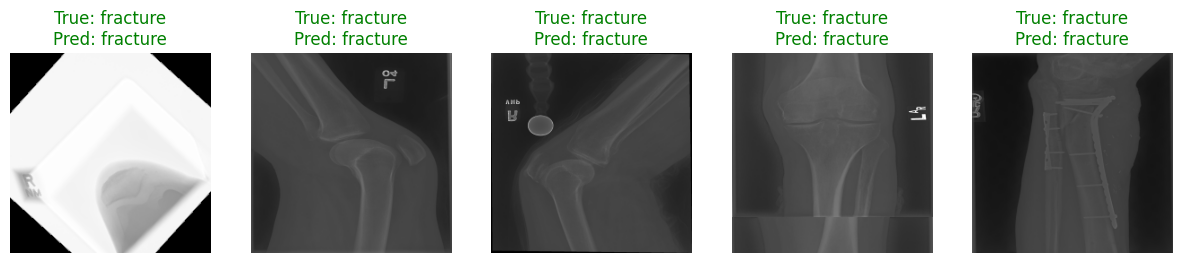

Number of layers in the best model: 7


In [14]:
# --- STAGE 1: EVALUATION ON THE FIRST TEST SET (from main_data_dir) ---
print("\n--- Best Model Details ---")
print(f"Best Config (dropout, lr, batch, epochs): {best_config}")
print(f"Best Validation Accuracy during training: {best_accuracy:.2%}")
evaluate_and_report(best_model, test1_x, test1_y, class_names, "First Test Set")
print(f"Number of layers in the best model: {len(best_model.layers)}")




Loading the second, final hold-out test set...
Found 60 files belonging to 2 classes.

--- Evaluation on Second (Final) Test Set ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step

Second (Final) Test Set Accuracy: 93.33%
Second (Final) Test Set F1 Score: 93.30%

Classification Report:
              precision    recall  f1-score   support

    fracture       0.88      1.00      0.94        30
      normal       1.00      0.87      0.93        30

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60


Confusion Matrix:


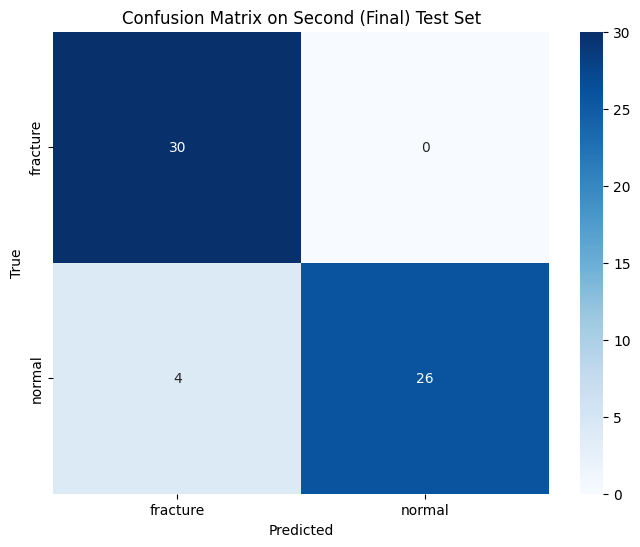


--- Sample of Correctly Classified Images from Second (Final) Test Set ---


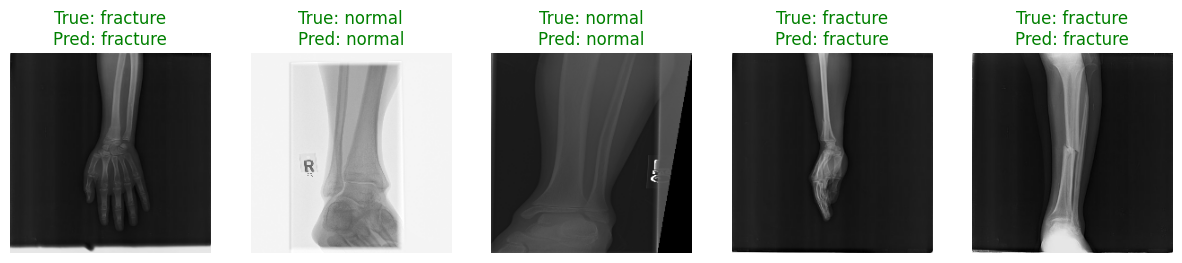

In [15]:

# --- STAGE 2: EVALUATION ON THE SECOND (FINAL) TEST SET ---
print("\nLoading the second, final hold-out test set...")
test2_x, test2_y = load_second_test_set(second_test_dir)
evaluate_and_report(best_model, test2_x, test2_y, class_names, "Second (Final) Test Set")
